In [38]:
# Built-in modules
import math
from sys import maxsize
from collections import Counter

# Imports from Qiskit
from qiskit import QuantumCircuit, transpile
from qiskit import compiler
from qiskit.circuit.library import GroverOperator, MCMT, ZGate
from qiskit.visualization import plot_distribution
from qiskit.transpiler.passes import RemoveBarriers
from qiskit_ibm_provider import IBMProvider
from qiskit_ibm_runtime import Options
from qiskit.visualization import plot_circuit_layout
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager



# import basic plot tools
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

# Imports from Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Batch

#DAG
from qiskit.dagcircuit import DAGCircuit
from qiskit.converters import circuit_to_dag
from qiskit.visualization import dag_drawer

#### INPUT: ####

In [39]:
marked_states = ["000"]
numShots = 10000
simulazione = False
useBackendName = True
if(simulazione == True):
    #USE BACKEND NAME
    backendName = "ibmq_qasm_simulator"
else:
    backendName = "ibm_osaka"

#METTI LE BARRIERE NEL CIRCUITO
barriers = True

#ATTIVAZIONE DELL'ERROR CORRECTION
ErrorCorrection = False
#ENCODE ON OFF
ErrorCorrectionEncoding = False
#DECODE ON OFF
ErrorCorrectionDecoding = False
#PHASE FLIP
ErrorCorrectionWithHGates = False
#ERRORE DOPO LA MISURAZIONE
ErrorCorrectionAfterMeasurament = True
#QUESTA VARIABILE SE SETTATA A 0 USA IL NUMERO DI INTERACTIONS TRAMITE LA FORMULA MENTRE SE SETTATO AD UN NUMERO > 0 FARE UN NUMERO DI INTERAZIONI PARI AL NUMERO SPECIFICATO
UsingOptimalNumInteractions = 0
IBMComputerNumeroQubits = 128 
ECR_GateLength = 660
SX_GateLength = 60
X_GateLength = 60
RZ_GateLength = 0
ID_GateLength = 60
#TOKEN
myToken = ""

num_qubits = len(marked_states[0])

if(ErrorCorrection == False):
    ErrorCorrectionEncoding = False
    ErrorCorrectionAfterMeasurament = False
    ErrorCorrectionDecoding = False
print(num_qubits)

3


In [40]:
service = QiskitRuntimeService(
        channel="ibm_quantum", 
        token=myToken)
if(useBackendName == False):
    #simulator TRUE O FALSE IMPORTANTE!!!
    backend = service.least_busy(operational=True, simulator=simulazione, memory = backendUseMemory)
else:
    backend = service.backend(backendName)  
backend.name

'ibm_osaka'

In [41]:
def PhaseCorrectionEncode(marked_states,qc):
    for indexQubit in range(num_qubits):
        qc.cx(indexQubit*3,indexQubit*3+1) 
        qc.cx(indexQubit*3,indexQubit*3+2)
        if(ErrorCorrectionWithHGates == True):
            qc.h(indexQubit*3)
            qc.h(indexQubit*3+1)
            qc.h(indexQubit*3+2)
    if(barriers == True):
            qc.barrier()
    return qc

In [42]:
def PhaseCorrectionDecode(marked_states,qc):
    if(barriers == True):
        qc.barrier() 
    for indexQubit in range(num_qubits):
        if(ErrorCorrectionWithHGates == True):
            qc.h(indexQubit*3)
            qc.h(indexQubit*3+1)
            qc.h(indexQubit*3+2)
        qc.cx(indexQubit*3,indexQubit*3+1) 
        qc.cx(indexQubit*3,indexQubit*3+2)
        qc.ccx(indexQubit*3+2,indexQubit*3+1,indexQubit*3)    
 
    return qc

In [43]:
def grover_oracle(marked_states,qc):
    for target in marked_states:
        # Si flippano i bit per matchare l'ordinamento al contrario di Qskit
        rev_target = target[::-1]
        # Trovo gli zeri nella stringa
        zero_inds = [ind for ind in range(num_qubits) if rev_target.startswith("0", ind)]
        #Metto il gate X prima e dopo i qbits con 0. 
        qc.x(zero_inds)
        qc.h(num_qubits-1)
        qc.mcx(list(range(num_qubits-1)),num_qubits-1)
        qc.h(num_qubits-1)
        qc.x(zero_inds)
        print(range(num_qubits))
        if(barriers == True):
            qc.barrier()
    return qc

In [44]:
def multiples(value, length, c):
    return [(value * i) + c for i in range(0, length)]

In [45]:
def groverOracleErrorCorrection(marked_states,qc):
    for target in marked_states:
        # Si flippano i bit per matchare l'ordinamento al contrario di Qskit
        rev_target = target[::-1]
        # Trovo gli zeri nella stringa
        zero_inds = [ind for ind in range(num_qubits) if rev_target.startswith("0", ind)]
        #Metto il gate X prima e dopo i qbits con 0. 
        for indice in zero_inds:
            qc.x(indice * 3)
            qc.x((indice * 3)+ 1)
            qc.x((indice * 3)+ 2)
        qc.h(num_qubits*3-1)
        qc.h(num_qubits*3-2)
        qc.h(num_qubits*3-3)
        qc.mcx(list(multiples(3,num_qubits-1,0)),num_qubits*3-3)
        qc.mcx(list(multiples(3,num_qubits-1,1)),num_qubits*3-2)
        qc.mcx(list(multiples(3,num_qubits-1,2)),num_qubits*3-1)
        qc.h(num_qubits*3-3)
        qc.h(num_qubits*3-2)
        qc.h(num_qubits*3-1)
        for indice in zero_inds:
            qc.x(indice * 3)
            qc.x((indice * 3)+ 1)
            qc.x((indice * 3)+ 2)
            #print(range(num_qubits))
    if(barriers == True):
        qc.barrier()
    return qc

In [46]:
def groverOperatorErrorCorrection(marked_states,qc):
    for indexQubit in range(num_qubits):
        qc.h(indexQubit*3)
        qc.h(indexQubit*3+1)
        qc.h(indexQubit*3+2)
        qc.x(indexQubit*3)
        qc.x(indexQubit*3+1)
        qc.x(indexQubit*3+2)
    qc.h(num_qubits*3-3)
    qc.h(num_qubits*3-2)
    qc.h(num_qubits*3-1)
    qc.mcx(list(multiples(3,num_qubits-1,0)),num_qubits*3-3)
    qc.mcx(list(multiples(3,num_qubits-1,1)),num_qubits*3-2)
    qc.mcx(list(multiples(3,num_qubits-1,2)),num_qubits*3-1)
    qc.h(num_qubits*3-3)
    qc.h(num_qubits*3-2)
    qc.h(num_qubits*3-1)
    for indexQubit in range(num_qubits):
        qc.x(indexQubit*3)
        qc.x(indexQubit*3+1)
        qc.x(indexQubit*3+2)
        qc.h(indexQubit*3)
        qc.h(indexQubit*3+1)
        qc.h(indexQubit*3+2)  
    if(barriers == True):
            qc.barrier()
    return qc

In [47]:
def groverOperator(marked_states,qc):
    print(num_qubits)
    for indexQubit in range(num_qubits):
        qc.h(indexQubit)
        qc.x(indexQubit)
    qc.h(num_qubits-1)
    qc.mcx(list(range(num_qubits-1)),num_qubits-1)
    qc.h(num_qubits-1)
    for indexQubit in range(num_qubits):
        qc.x(indexQubit)
        qc.h(indexQubit)
    if(barriers == True):
            qc.barrier()
    return qc

In [48]:
optimal_num_iterations = math.floor(
    math.pi / 4 * math.sqrt(2**num_qubits / len(marked_states))
)

In [49]:
if(ErrorCorrection == True):
    if(ErrorCorrectionAfterMeasurament == True):
        qc = QuantumCircuit(num_qubits*3,num_qubits*3)
    else:
        qc = QuantumCircuit(num_qubits*3,num_qubits)
    if(ErrorCorrectionEncoding == True):
        bho = PhaseCorrectionEncode(marked_states,qc)
    for index in range(num_qubits*3):
        qc.h(index)
else:
    qc = QuantumCircuit(num_qubits,num_qubits)
    for index in range(num_qubits):
            qc.h(index)

In [50]:
if (UsingOptimalNumInteractions == 0):
    for index in range(optimal_num_iterations):
        if(ErrorCorrection == True):
            oracle = groverOracleErrorCorrection(marked_states,qc)
            grover_op = groverOperatorErrorCorrection(marked_states,qc)
        else:
            oracle = grover_oracle(marked_states,qc)
            grover_op = groverOperator(oracle,qc)
else:
    for index in range(UsingOptimalNumInteractions):
        if(ErrorCorrection == True):
            oracle = groverOracleErrorCorrection(marked_states,qc)
            grover_op = groverOperatorErrorCorrection(marked_states,qc)
        else:
            oracle = grover_oracle(marked_states,qc)
            grover_op = groverOperator(oracle,qc)
#grover_op.draw(output="mpl", style="iqp") 

range(0, 3)
3
range(0, 3)
3


In [51]:
if(ErrorCorrectionDecoding == True):
    PhaseCorrectionDecode(marked_states,qc)
#qc.draw(output="mpl", style="iqp") 

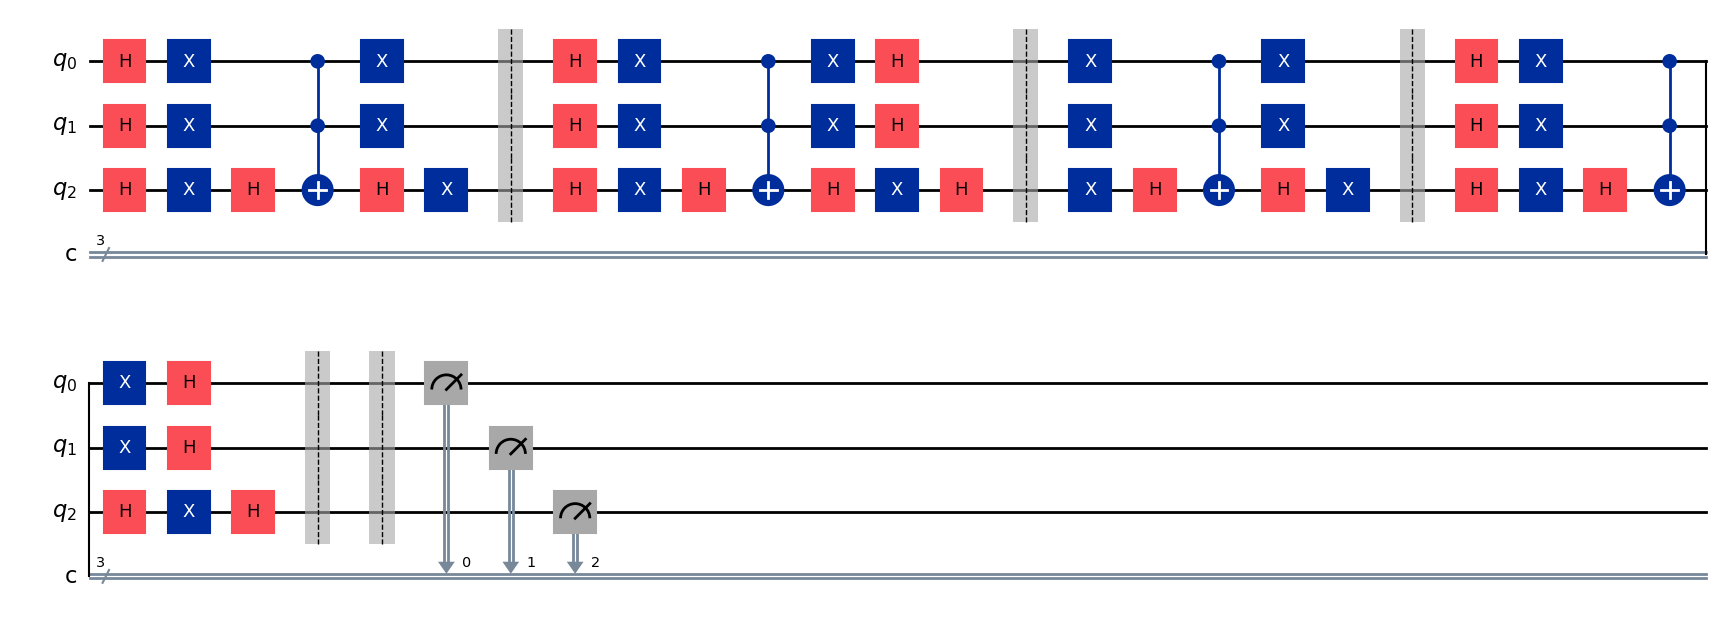

In [52]:
qc.barrier()
if(ErrorCorrection == True):
    if(ErrorCorrectionAfterMeasurament == True):
        for index in range(qc.num_qubits):
            qc.measure(index,index)
    else:
        for index in range(num_qubits):
            qc.measure(index*3,index)
else:
    for index in range(num_qubits):
            qc.measure(index,index)
qc.draw(output="mpl", style="iqp") 

In [53]:
target = backend.target
pm = generate_preset_pass_manager(
        target=target, 
        optimization_level=3
     )
qc_transpiled = pm.run(qc)
qc_transpiled.draw(filename="Circuito.txt",idle_wires=False,fold=maxsize)

global phase: 5π/4
            ┌──────────┐ ┌────┐ ┌────────────┐┌──────┐     ┌───┐     ┌──────────────┐                                                                                                    ┌──────┐  ┌──────────┐                                                                                                                                         ┌──────┐                                                          ┌──────┐ ┌────────┐                                          ░ ┌─────────┐ ┌────┐┌────────────┐                                                                                                                                         ┌──────┐ ┌────────────┐                                                                                                          ┌──────┐     ┌───┐     ┌───────────┐                                                                                                                               ┌──────┐                                                          ┌──────┐   ┌─────────┐   ┌────┐  ┌──────────┐                       ░    ┌───┐                                                                                                                                                 ┌──────┐      ┌───┐                                                                                                                ┌──────┐  ┌──────────┐                                                                                                                                         ┌──────┐                                                          ┌──────┐ ┌────────┐                                          ░ ┌─────────┐ ┌────┐┌────────────┐                                                                                                                                         ┌──────┐ ┌────────────┐                                                                                                          ┌──────┐     ┌───┐     ┌───────────┐                                                                                                                               ┌──────┐                                                          ┌──────┐   ┌─────────┐   ┌────┐  ┌──────────┐                       ░    ┌─┐   
q_1 -> 24 ──┤ Rz(-π/2) ├─┤ √X ├─┤ Rz(2.3928) ├┤0     ├─────┤ X ├─────┤ Rz(-0.82202) ├────────────────────────────────────────────────────────────────────────────────────────────────────┤0     ├──┤ Rz(-π/4) ├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤0     ├──────────────────────────────────────────────────────────┤0     ├─┤ Rz(-π) ├──────────────────────────────────────────░─┤ Rz(π/2) ├─┤ √X ├┤ Rz(2.8092) ├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤0     ├─┤ Rz(1.2384) ├──────────────────────────────────────────────────────────────────────────────────────────────────────────┤0     ├─────┤ X ├─────┤ Rz(-3π/4) ├───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤0     ├──────────────────────────────────────────────────────────┤0     ├───┤ Rz(π/2) ├───┤ √X ├──┤ Rz(-π/2) ├───────────────────────░────┤ X ├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤0     ├──────┤ X ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤0     ├──┤ Rz(-π/4) ├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤0     ├──────────────────────────────────────────────────────────┤0     ├─┤ Rz(-π) ├──────────────────────────────────────────░─┤ Rz(π/2) ├─┤ √X ├┤ Rz(2.8092) ├──────────────────────────────────────────────────────────

In [54]:
dag = circuit_to_dag(qc_transpiled)
if(simulazione == False):
    idle_wires = list(dag.idle_wires())
    for w in idle_wires:
        dag._remove_idle_wire(w)
        dag.qubits.remove(w)

In [55]:
dagNumGates = dag.count_ops_longest_path()
longestPathLength = 0
longestPathNumGates = 0
dagNumGates.pop('barrier',None)
dagNumGates.pop('measure',None)
for key in dagNumGates.keys():
    if key == "ecr" :
        longestPathLength += ECR_GateLength * dagNumGates.get(key)
        longestPathNumGates += dagNumGates.get(key)
    if key == "id":
        longestPathLength += ID_GateLength * dagNumGates.get(key)
        longestPathNumGates += dagNumGates.get(key)
    if key == "sx":
        longestPathLength += SX_GateLength * dagNumGates.get(key)
        longestPathNumGates += dagNumGates.get(key)
    if key == "x":
        longestPathLength += X_GateLength * dagNumGates.get(key)
        longestPathNumGates += dagNumGates.get(key)
    if key == "rz":
        longestPathLength += RZ_GateLength * dagNumGates.get(key)
        longestPathNumGates += dagNumGates.get(key)    
print("Numero di Gates nel longest Path: " + str(longestPathNumGates) + "\nLength / Duration: " + str(longestPathLength) + " ns") 
dagNumGates

Numero di Gates nel longest Path: 211
Length / Duration: 28800 ns


{'rz': 101, 'sx': 73, 'ecr': 37}

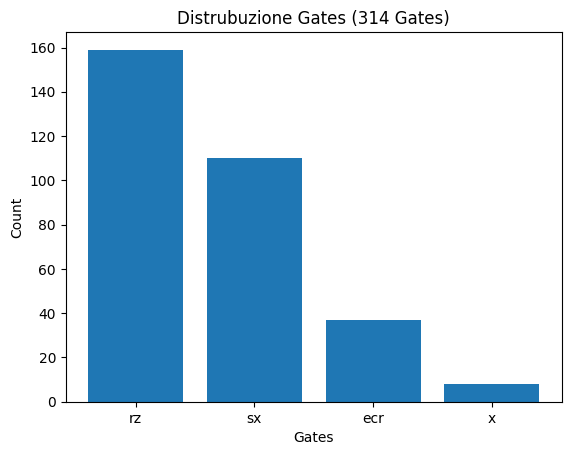

In [56]:
dictionaryGates = dag.count_ops()
dictionaryGates.pop('barrier',None)
dictionaryGates.pop('measure',None)
totalGates = 0
for key in dictionaryGates.keys():
    totalGates += dictionaryGates.get(key)
plt.bar(dictionaryGates.keys(), dictionaryGates.values())
plt.xlabel('Gates')
plt.ylabel('Count')
plt.title('Distrubuzione Gates (' +str(totalGates) +' Gates)')
plt.show()

In [114]:
with Batch(backend=backend) as batch:
    sampler = Sampler()
    job = sampler.run(
        qc_transpiled,
        skip_transpilation=True,
        shots=numShots,
        resilience_level = 1,
    )

c:\VisualStudio\ProgettoQUANTUM\Qskit\Lib\site-packages\qiskit_ibm_runtime\qiskit_runtime_service.py:927: UserWarning: Starting a session using the /jobs endpoint will no longer be supported after March 31, 2024. Please update your code as soon as possible before this date. If you are using qiskit-ibm-runtime, you will need version 0.20.0 or higher. If you are using qiskit-ibm-provider, you will need version 0.10.0 or higher. If you are calling the API directly, please use the /sessions endpoint instead.
  warnings.warn(warning_message)


In [ ]:
result = job.result()
dist = result.quasi_dists[0]
binaryprob = dist.binary_probabilities()
keys = list(binaryprob.keys())
valuesprob = list(binaryprob.values())

In [ ]:
#ERROR CORRECTION DOPO LA MISURAZIONE 
if(ErrorCorrectionAfterMeasurament == True):
    dataCorrected = [""]*len(keys)
    dataProbability = [0]*(2**num_qubits)
    for i in range(len(keys)):
        for j in range(num_qubits):
            somma = 0
            for c in range(3):
                somma += int(keys[i][c*num_qubits + j])
            if(somma >= 2):
                dataCorrected[i] += "1"
            else:
                dataCorrected[i] += "0"
        dataProbability[int(dataCorrected[i], 2)] += valuesprob[i]